In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [6]:
main_path = "/kaggle/input"

paths = []
labels = []

for dirname, _, filenames in os.walk(main_path):
  for filename in filenames:
    paths.append(os.path.join(dirname, filename))
    label = filename.split('_')[-1]
    label = label.split(".")[0]
    labels.append(label.lower())

print("Dataset is loaded.")


Dataset is loaded.


In [7]:
# Creating Dataframe
data_df = pd.DataFrame()
data_df['speech_paths'] = paths
data_df['labels'] = labels
data_df['labels'] = data_df['labels'].astype('category')
data_df.head()


,speech_paths,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [8]:
len(paths)


5600

In [9]:
data_df['labels'].value_counts()


labels
angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: count, dtype: int64

In [11]:
def waveplotting(data, sr, emotion):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(data, sr=sr)
  plt.title(emotion, size=10)
  plt.show()

def spectrogram(data, sr, emotion):
  plt.figure(figsize=(10, 4))
  D = librosa.amplitude_to_db(abs(librosa.stft(data)))
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')
  plt.title(emotion, size=10)
  plt.show()

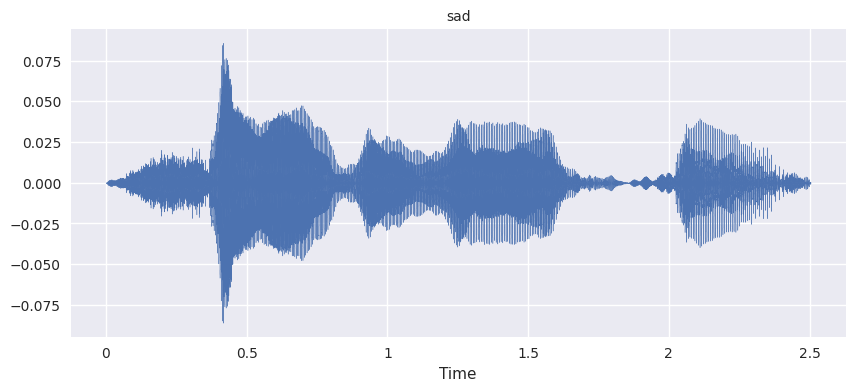

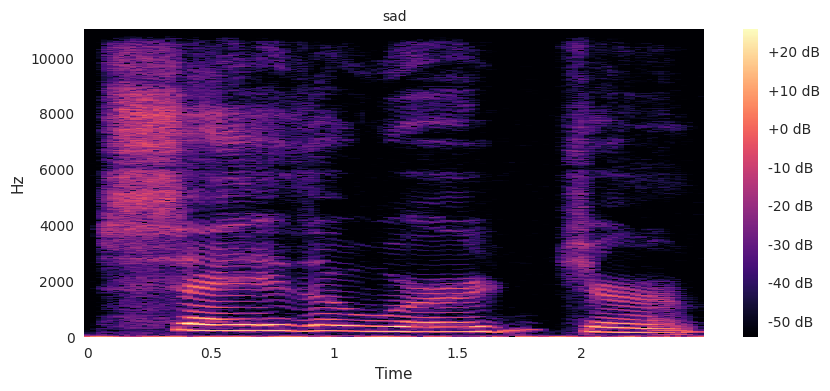

In [12]:
emotion = 'sad'
path = data_df['speech_paths'][data_df['labels'] == emotion].values[0]
data, sr = librosa.load(path)
waveplotting(data, sr, emotion)
spectrogram(data, sr, emotion)
Audio(path)

In [13]:
def extract_mfcc(filename):
  data, sr = librosa.load(filename, duration=3, offset=0.5)
  mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
  return mfccs

extract_mfcc(path)

array([-5.4590045e+02,  1.0327704e+02,  2.8864670e+01,  1.2691002e+01,
        2.5945904e+01,  1.7037203e+01, -6.1091142e+00, -1.6700800e+01,
       -1.8066669e+01,  2.6380229e+00, -1.5536851e+01, -6.1414452e+00,
       -5.3670293e-01,  9.0229034e-01, -4.2382369e+00, -3.3982482e+00,
       -7.0691609e-01, -3.3789694e-01,  2.2835968e+00, -4.9155531e+00,
        5.0979543e+00, -5.0838671e+00, -4.9878283e+00, -3.4258387e+00,
       -7.0797443e+00,  2.1534839e+00, -5.7315960e+00,  1.4180739e+00,
       -4.3242112e-01,  3.3441913e-01,  1.5426435e+00,  1.1107642e+01,
        7.2118354e+00,  1.0925085e+01,  1.2836203e+01,  1.0258159e+01,
        5.3608122e+00,  1.2656720e+01,  9.9677553e+00,  1.5807195e+01],
      dtype=float32)

In [14]:
X_mfcc = data_df['speech_paths'].apply(lambda x: extract_mfcc(x))
x_mfcc = np.array([x for x in X_mfcc])
x_mfcc.shape

(5600, 40)

In [15]:
# For LSTM model, expanding dimentions
x = np.expand_dims(x_mfcc, axis=2)
x.shape

(5600, 40, 1)

In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(data_df['labels']).reshape(-1,1)).toarray()
y.shape

(5600, 7)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(123, return_sequences=False, input_shape=(40, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 123)               61500     
                                                                 
 dense (Dense)               (None, 64)                7936      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 71747 (280.26 KB)
Trainable params: 71747 

In [18]:
model.fit(x, y, 
          epochs=100, 
          batch_size=512, 
          validation_split=0.2, 
          shuffle = True)

Epoch 1/100
9/9 [==============================] - 5s 273ms/step - loss: 1.8521 - accuracy: 0.3118 - val_loss: 1.9655 - val_accuracy: 0.1268
Epoch 2/100
9/9 [==============================] - 2s 170ms/step - loss: 1.5622 - accuracy: 0.5547 - val_loss: 1.9987 - val_accuracy: 0.1071
Epoch 3/100
9/9 [==============================] - 2s 173ms/step - loss: 1.1161 - accuracy: 0.6763 - val_loss: 1.8740 - val_accuracy: 0.1705
Epoch 4/100
9/9 [==============================] - 2s 192ms/step - loss: 0.7964 - accuracy: 0.7433 - val_loss: 1.2794 - val_accuracy: 0.4161
Epoch 5/100
9/9 [==============================] - 2s 170ms/step - loss: 0.6067 - accuracy: 0.7908 - val_loss: 1.0219 - val_accuracy: 0.5357
Epoch 6/100
9/9 [==============================] - 2s 172ms/step - loss: 0.4762 - accuracy: 0.8319 - val_loss: 0.8171 - val_accuracy: 0.6339
Epoch 7/100
9/9 [==============================] - 2s 192ms/step - loss: 0.3945 - accuracy: 0.8607 - val_loss: 0.6908 - val_accuracy: 0.7125
Epoch 8/100
9